In [4]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt

sys.path.append('ComputableInformationDensity_dev')
from ComputableInformationDensity_dev.cid import interlaced_time, cid2d, CID, CID_old
from ComputableInformationDensity_dev.computable_information_density import cid, cid_shuffle
from ComputableInformationDensity_dev.hilbert_curve import *

from utils import timeit, get_allowed_time_intervals, block_flatten

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

In [2]:
# possibly extent to more activities
LX = 512
base_path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LX}l_cl'
d_cluster = dict(path = base_path + '_cl', \
              suffix = "l_cl", priority = 1, LX = LX, Nframes = 400)
d_cluster_l = dict(path = base_path + 'l_cl', \
              suffix = "l_cl", priority = 1, LX = LX, Nframes = 400)
d_cluster_vl = dict(path = base_path + 'vl_cl', \
              suffix = "vl_cl", priority = 1, LX = LX, Nframes = 1500)
d_list = [d_cluster_l, d_cluster_vl]


## Choose which dataset to visualize
act = 0.024 #22 
num_exp = 0

folder_path = os.path.join(base_path, f'analysis_zeta_{act}',  f'zeta_{act}_counter_{num_exp}')
defect_path = os.path.join(folder_path, 'defect_positions.pkl')

with open(defect_path, 'rb') as f:
    top_defects = pkl.load(f)


In [24]:
data_shape = (6,7,8,15,16)
[(s-1).bit_length() for s in data_shape]

[3, 3, 3, 4, 4]

In [9]:
Nt, Nx, Ny, Nz = 2, 16,16,16
data_shape = (Nx, Ny, Nz)
nbits = max((s-1).bit_length() for s in data_shape)
Npoints = np.prod(data_shape)
nshuffle=8
dim=len(data_shape)
arr=np.linspace(0,Npoints-1,Npoints).reshape(data_shape).astype(np.uint32)
arr = np.random.binomial(1,0.09,size=data_shape).astype(np.uint8)

CIDzz = CID(nbits=nbits,dim=dim,nshuff=4, ordering='zcurve', data_shape=data_shape, verbose=False)
CIDi = CID(nbits=nbits,dim=dim,nshuff=4, ordering='hilbert', verbose=False)
CIDii=CID_old(dim=dim,nbits=nbits, nshuff=4, verbose=False)
#CIDzz(arr)
print("Z-curve CID:", CIDzz(arr), "\nHilbert CID:", CIDi(arr), "\nCID_old:", CIDii(arr))

Z-curve CID: (0.5760020064951831, 0.0036907128197439664, (0.5719221801597165, 0.0035699285713088084), [0.5690975646886262, 0.5766358343817638, 0.5804011863554126, 0.5690975646886262, 0.5690975646886262, 0.5916823241680437]) 
Hilbert CID: (0.5719218793494053, 0.002441723206854008, (0.5671827025758689, 0.010285374917823848), [0.5615490853491099, 0.5728679665262286, 0.5728679665262286, 0.5653246105064472, 0.5728679665262286, 0.5766358343817638, 0.5841640402906092, 0.5690975646886262]) 
CID_old: (0.5719218793494053, 0.002441723206854008, (0.5738061459623784, 0.0038835419820253654), [0.5615490853491099, 0.5728679665262286, 0.5728679665262286, 0.5653246105064472, 0.5728679665262286, 0.5766358343817638, 0.5841640402906092, 0.5690975646886262])


#### Iterative coarse-graining

In [ ]:
dtype = np.uint8
cid_mode = 'lz77'
verbose = True

compression_factor = 1
coarse_graining_box_length = 1

njumps_between_frames = 1
top_defects = top_defects[::njumps_between_frames]

num_frames = len(top_defects)
nframes_to_analyze = min(150, num_frames)
npartitions = compression_factor**2

LX_cg = LX // coarse_graining_box_length
lx_window = LX // compression_factor
lx_window_cg = lx_window // coarse_graining_box_length

nbits_frame = int(np.log2(lx_window_cg))
nframes_per_cube = 1
time_subinterval = 1
ncubes = 1 + int(((nframes_to_analyze - nframes_per_cube) / time_subinterval))
first_frame_idx = (num_frames - nframes_to_analyze) + (nframes_to_analyze - nframes_per_cube - ((ncubes - 1) * time_subinterval))


defect_grid_full = np.zeros((num_frames - first_frame_idx, LX_cg, LX_cg), dtype=dtype)

cg_box_lens = [2**i for i in range(1,6)]

defect_count_cg = np.zeros((num_frames - first_frame_idx, 1 + len(cg_box_lens), 2), dtype=float)

# Step 1: Build defect grids without coarse graining
for i, defect in enumerate(top_defects[first_frame_idx:]):
    def_arr = get_defect_arr_from_frame(defect).astype(int)

    def_arr_xmask = (0 < def_arr[:,0]) & (def_arr[:,0] < lx_window)
    def_arr_ymask = (0 < def_arr[:,1]) & (def_arr[:,1] < lx_window)
    def_arr = def_arr[def_arr_xmask & def_arr_ymask]

    defect_grid_full[i, def_arr[:, 0], def_arr[:, 1]] = 1

    ndef = len(def_arr)
    defect_count_cg[i, 0, 0 ] = ndef
    defect_count_cg[i, 0, 1 ] = ndef / lx_window**2

# Step 2: Coarse grain defect grids and compute defect counts
if 1:
    for j, box_len in enumerate(cg_box_lens):
        nboxes_per_side = lx_window // box_len

        print(box_len, nboxes_per_side)

        defect_grid_reshaped = defect_grid_full.reshape(defect_grid_full.shape[0], LX_cg//box_len, box_len, LX_cg//box_len, box_len).transpose(0,1,3,2,4).astype(float)
        defect_grid_cg = defect_grid_reshaped.mean(axis=(-2,-1)) # / nboxes_per_side**2 # (box_len**2)
        density_cg = defect_grid_cg.mean(axis=(-2,-1))
        density_cg = defect_grid_reshaped.sum(axis=(-2,-1)).mean(axis=(-2,-1)) #/ box_len**2

        print("dens rs :", )
        print(defect_grid_cg[0][:2,:2])
        print(density_cg[0])

        print("CG dens:", defect_grid_reshaped.sum(axis=(-2,-1)).mean(axis=(-2,-1))[0] / box_len**2)

       # print(defect_grid_reshaped.sum(axis=(-2,-1)),)
       # print(defect_grid_reshaped.sum(axis=(-2,-1))[0,:2,:2],)
       # print(defect_grid_reshaped.shape, defect_grid_reshaped.mean(axis=(-2,-1))[0,:2,:2], )
       # print(density_grid_cg.shape, density_grid_cg[0,:2,:2])
       # density_mask = (density_grid_cg > defect_count_cg[:,0,1][:,None,None])# * (box_len**2) )
        density_mask = (defect_grid_cg > density_cg[:,None,None] / box_len**2)

        defect_grid_cg[density_mask] = 1
        defect_grid_cg[~density_mask] = 0

        ndefs = defect_grid_cg.sum(axis=(-2,-1))
        defect_count_cg[:, j + 1, 0] = ndefs
        defect_count_cg[:, j + 1, 1] = ndefs / (nboxes_per_side**2)


with warnings.catch_warnings():
    # ignore runtime warnings from cid calculation
    warnings.simplefilter("ignore", RuntimeWarning)
#print("defects lost in coarse graining per frame: ", np.mean(np.array(defect_count_full) - np.array(defect_count)))

In [ ]:
bl = 4
defect_grid_full[11,1,:20] = np.linspace(1,20,20)
dd = defect_grid_full.reshape(defect_grid_full.shape[0], LX_cg//bl, bl, LX_cg//bl, bl).transpose(0,1,3,2,4)
#bf = block_flatten(dd, 4, 4)
#dd[:4,:12], bf[:3,0,:,:]
r0=0
defect_grid_full[11,r0:r0+4,:20], dd[11,0,:5,:,:]

In [ ]:
# Coarse-grain: map positions to coarse grid indices
    coarse_x = (def_arr[:, 0] // coarse_graining_box_length).astype(int)
    coarse_y = (def_arr[:, 1] // coarse_graining_box_length).astype(int)

    # Set coarse cells to 1 if any defect is inside
    defect_grid_full[i, coarse_x, coarse_y] = 1
    defect_count.append(defect_grid_full[i,:,:].sum())

#### Coarse-graining of several windows

In [6]:
## we will:
# assume square partion starting from bounds of system


dtype = np.uint8
cid_mode = 'lz77'
verbose = True

compression_factor = 2
coarse_graining_box_length = 4
overlap = 0
nshuffle = 1
nbits = 5

njumps_between_frames = 1
top_defects = top_defects[::njumps_between_frames]

num_frames = len(top_defects)
nframes_to_analyze = min(150, num_frames)
npartitions = compression_factor**2

LX_cg = LX // coarse_graining_box_length
lx_window = LX // compression_factor
lx_window_cg = lx_window // coarse_graining_box_length

nbits_frame = int(np.log2(lx_window_cg))
nframes_per_cube = get_allowed_time_intervals(system_size = lx_window_cg, nbits_max=nbits)[-1]['time_interval']
time_subinterval = nframes_per_cube - overlap
ncubes = 1 + int(((nframes_to_analyze - nframes_per_cube) / time_subinterval))
first_frame_idx = (num_frames - nframes_to_analyze) + (nframes_to_analyze - nframes_per_cube - ((ncubes - 1) * time_subinterval))


defect_grid = np.zeros((num_frames - first_frame_idx, LX_cg, LX_cg), dtype=dtype)
defect_count_full = []
defect_count = []

print(f'nboxes per frame = {compression_factor**2}')
print(f"Using window size {lx_window}x{lx_window}.")
print(f"nf_cube,lx_cg,ly_cg= {nframes_per_cube}x{lx_window_cg}x{lx_window_cg}")
print(f"Hypercube shape: {1 << nbits}x{1 << nbits}x{1 << nbits}")
print(f"ncubes: {ncubes}")

for i, defect in enumerate(top_defects[first_frame_idx:]):
    def_arr = get_defect_arr_from_frame(defect).astype(int)

    #def_arr_xmask = (observation_window_bounds[0][0] < def_arr[:,0]) & (def_arr[:,0] < observation_window_bounds[0][1])
    #def_arr_ymask = (observation_window_bounds[0][0] < def_arr[:,1]) & (def_arr[:,1] < observation_window_bounds[0][1])
    #def_arr = def_arr[def_arr_xmask & def_arr_ymask]

    defect_count_full.append(len(def_arr))

    # Coarse-grain: map positions to coarse grid indices
    coarse_x = (def_arr[:, 0] // coarse_graining_box_length).astype(int)
    coarse_y = (def_arr[:, 1] // coarse_graining_box_length).astype(int)

    # Set coarse cells to 1 if any defect is inside
    defect_grid[i, coarse_x, coarse_y] = 1
    defect_count.append(defect_grid[i,:,:].sum())

print(defect_count_full)
print(f"Average number of defects in window before/after coarse graining: {np.mean(defect_count_full):.2f}, {np.mean(defect_count):.2f}")
#print("defects lost in coarse graining per frame: ", np.mean(np.array(defect_count_full) - np.array(defect_count)))

nboxes per frame = 4
Using window size 256x256.
nf_cube,lx_cg,ly_cg= 8x64x64
Hypercube shape: 32x32x32
ncubes: 18
[430, 437, 440, 456, 448, 449, 445, 424, 422, 427, 431, 436, 437, 437, 443, 440, 445, 449, 442, 440, 443, 462, 452, 447, 442, 440, 441, 438, 438, 429, 437, 445, 438, 438, 438, 434, 432, 437, 440, 442, 447, 447, 450, 448, 449, 448, 444, 434, 435, 439, 436, 445, 447, 432, 440, 447, 451, 442, 432, 424, 429, 428, 427, 423, 420, 419, 426, 427, 433, 424, 422, 426, 420, 425, 432, 431, 434, 430, 426, 426, 435, 434, 425, 428, 431, 435, 432, 436, 445, 439, 432, 435, 437, 440, 438, 440, 438, 419, 419, 415, 411, 408, 415, 406, 401, 396, 399, 397, 392, 386, 384, 370, 378, 384, 392, 388, 397, 400, 403, 410, 412, 410, 419, 424, 410, 400, 396, 399, 409, 408, 409, 408, 408, 404, 408, 412, 412, 408, 410, 422, 422, 416, 420, 424]
Average number of defects in window before/after coarse graining: 426.36, 422.48


In [ ]:


Nt,Nx,Ny=2,2,2
nshuffle=4
nbits = int(np.log2(Nx) )
dim=3
arr=np.linspace(0,Nt*Nx*Ny-1,Nt*Nx*Ny).reshape((Nt,Nx,Ny)).astype(np.uint32)
itter_hscan(arr, nbits=nbits, dim=dim)
arr_list = list(itter_hscan(arr, nbits=nbits, dim=dim))
arr_list
data_shape = (Nt, Nx, Ny)
zcurves=precompute_zcurves(data_shape, bits_per_dim=nbits)
#[zscan(arr, zcurve) for zcurve in zcurves]
CIDzz = CIDz(nbits=nbits,dim=dim,nshuff=4, ordering='zcurve', data_shape=data_shape, verbose=False)


[array([0, 4, 2, 6, 1, 5, 3, 7], dtype=uint32),
 array([0, 4, 1, 5, 2, 6, 3, 7], dtype=uint32),
 array([0, 2, 4, 6, 1, 3, 5, 7], dtype=uint32),
 array([0, 2, 1, 3, 4, 6, 5, 7], dtype=uint32),
 array([0, 1, 4, 5, 2, 3, 6, 7], dtype=uint32),
 array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint32)]

In [12]:
len(data_shape)

3

AttributeError: 'CIDz' object has no attribute 'length'

In [ ]:
hcurves = precompute_hcurves_gen(dim, nbits)
[hscan(arr, hcurve) for hcurve in hcurves]

In [ ]:
precompute_hcurves(dim,nbits)

In [2]:
Nt,Nx,Ny=2,2,2
nshuffle=4
nbits = int(np.log2(Nx) )
dim=3
arr=np.linspace(0,Nt*Nx*Ny-1,Nt*Nx*Ny).reshape((Nt,Nx,Ny)).astype(np.uint32)
itter_hscan(arr, nbits=nbits, dim=dim)
arr_list = list(itter_hscan(arr, nbits=nbits, dim=dim))
arr_list

[array([4, 0, 2, 6, 7, 3, 1, 5], dtype=uint32),
 array([6, 2, 0, 4, 5, 1, 3, 7], dtype=uint32),
 array([2, 6, 4, 0, 1, 5, 7, 3], dtype=uint32),
 array([4, 6, 2, 0, 1, 3, 7, 5], dtype=uint32),
 array([6, 4, 0, 2, 3, 1, 5, 7], dtype=uint32),
 array([2, 0, 4, 6, 7, 5, 1, 3], dtype=uint32),
 array([0, 2, 6, 4, 5, 7, 3, 1], dtype=uint32),
 array([0, 4, 6, 2, 3, 7, 5, 1], dtype=uint32)]

In [ ]:
for order in itter_hscan_gen(arr,dim, nbits):
    print(order)

In [8]:
### 3D CID

t3 = time.perf_counter()
CID = interlaced_time(nbits=nbits, nshuff=nshuffle,mode=cid_mode, verbose=False)
cid_arr = np.nan * np.ones((ncubes, npartitions, 2))
cid_shuffle_arr = np.nan * np.ones_like(cid_arr)
cid_frac_arr = np.nan * np.ones_like(cid_arr)

for j in range(ncubes)[:2]:
    print(f"Calculating CID for cube {j+1}/{ncubes}...", end=' ')
    for i in range(npartitions):
        x_start = (i % compression_factor) * lx_window_cg
        y_start = (i // compression_factor) * lx_window_cg
        data = defect_grid[j * time_subinterval:(j+1)*time_subinterval+overlap, x_start:x_start+lx_window_cg, y_start:y_start+lx_window_cg]
        #print(f"  partition {i+1}/{npartitions}, data sum = {data.sum()}")
        print(f'box bounds: [{x_start},{x_start+lx_window_cg}] x [{y_start},{y_start+lx_window_cg}]')
        cid_av, cid_std, cid_shuff = CID.__call2__(data)#CID(data)
        cid_arr[j, i, 0] = cid_av
        cid_arr[j, i, 1] = cid_std
        cid_shuffle_arr[j, i, :] = cid_shuff

cid_frac_arr[:, :, 0] = cid_arr[:, :, 0] / cid_shuffle_arr[:, :, 0]
cid_frac_arr[:, :, 1] = cid_frac_arr[:, :, 0] * np.sqrt( (cid_arr[:, :, 1]/cid_arr[:, :, 0])**2 + (cid_shuffle_arr[:, :, 1]/cid_shuffle_arr[:, :, 0])**2 )


Calculating CID for cube 1/37... box bounds: [0,32] x [0,32]
box bounds: [32,64] x [0,32]
box bounds: [0,32] x [32,64]
box bounds: [32,64] x [32,64]
Calculating CID for cube 2/37... box bounds: [0,32] x [0,32]
box bounds: [32,64] x [0,32]
box bounds: [0,32] x [32,64]
box bounds: [32,64] x [32,64]


In [9]:
cid_arr[...,0][:2]

array([[0.58744424, 0.57143789, 0.65705232, 0.61087832],
       [0.58931082, 0.59401166, 0.65705075, 0.62911347]])

In [7]:
cid_arr[...,0][:2]

array([[0.58744424, 0.57143789, 0.65705232, 0.61087832],
       [0.58931082, 0.59401166, 0.65705075, 0.62911347]])

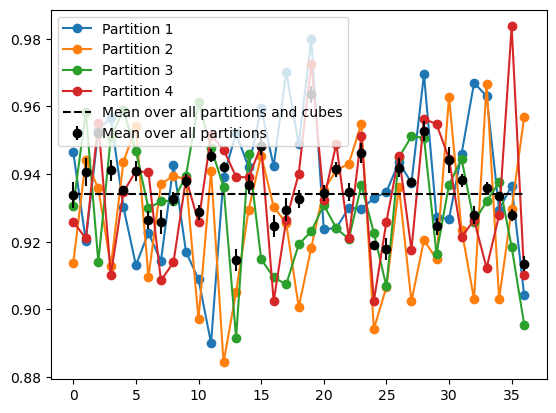

In [6]:
for i in range(npartitions):
    plt.plot(range(ncubes), cid_frac_arr[:, i, 0], marker='o', label=f'Partition {i+1}')

av_w, std_w = calc_weighted_mean(cid_frac_arr[:, :, 0].flatten(), cid_frac_arr[:, :, 1].flatten(), )
av_wt, std_wt = calc_weighted_mean(cid_frac_arr[:, :, 0], cid_frac_arr[:, :, 1],axis=-1 )
plt.hlines(av_w, 0, ncubes-1, colors='k', linestyles='dashed', label='Mean over all partitions and cubes')
plt.errorbar(range(ncubes), av_wt, yerr=std_wt, fmt='o', color='k', label='Mean over all partitions')
#plt.plot(range(ncubes), calc_weighted_mean(cid_frac_arr[:, :, 0], cid_frac_arr[:, :, 1]), marker='o', color='k', label='Mean over partitions')
plt.legend()

#### Coarse-graining of 1 window

In [5]:
dtype = np.uint8
cid_mode = 'lz77'
verbose = True

compression_factor = 2
coarse_graining_box_length = 4
overlap = 0
nshuffle = 8
nbits = 5

njumps_between_frames = 1
top_defects = top_defects[::njumps_between_frames]

num_frames = len(top_defects)
nframes_to_analyze = min(150, num_frames)

observation_window_bounds = [(0, int(LX / compression_factor)), (0, int(LX / compression_factor))]
lx_window = observation_window_bounds[0][1] - observation_window_bounds[0][0]
ly_window = observation_window_bounds[1][1] - observation_window_bounds[1][0]
lx_window_cg = lx_window // coarse_graining_box_length
ly_window_cg = ly_window // coarse_graining_box_length

nbits_frame = int(np.log2(lx_window_cg))
nframes_per_cube = get_allowed_time_intervals(system_size = lx_window_cg, nbits_max=nbits)[-1]['time_interval']
time_subinterval = nframes_per_cube - overlap
ncubes = 1 + int(((nframes_to_analyze - nframes_per_cube) / time_subinterval))
first_frame_idx = (num_frames - nframes_to_analyze) + (nframes_to_analyze - nframes_per_cube - ((ncubes - 1) * time_subinterval))


defect_grid = np.zeros((num_frames - first_frame_idx, lx_window_cg, ly_window_cg), dtype=dtype)
defect_count_full = []
defect_count = []

print(f"Using window size {lx_window}x{ly_window}.")
print(f"nf_cube,lx_cg,ly_cg= {nframes_per_cube}x{lx_window_cg}x{ly_window_cg}")
print(f"Hypercube shape: {1 << nbits}x{1 << nbits}x{1 << nbits}")
print(f"ncubes: {ncubes}")

for i, defect in enumerate(top_defects[first_frame_idx:]):
    def_arr = get_defect_arr_from_frame(defect).astype(int)

    def_arr_xmask = (observation_window_bounds[0][0] < def_arr[:,0]) & (def_arr[:,0] < observation_window_bounds[0][1])
    def_arr_ymask = (observation_window_bounds[0][0] < def_arr[:,1]) & (def_arr[:,1] < observation_window_bounds[0][1])
    def_arr = def_arr[def_arr_xmask & def_arr_ymask]

    defect_count_full.append(len(def_arr))

    local_x = def_arr[:, 0] - observation_window_bounds[0][0]
    local_y = def_arr[:, 1] - observation_window_bounds[1][0]

    # Coarse-grain: map positions to coarse grid indices
    coarse_x = (local_x // coarse_graining_box_length).astype(int)
    coarse_y = (local_y // coarse_graining_box_length).astype(int)

    # Set coarse cells to 1 if any defect is inside
    defect_grid[i, coarse_x, coarse_y] = 1
    defect_count.append(defect_grid[i,:,:].sum())

print(f"Average number of defects in window before/after coarse graining: {np.mean(defect_count_full):.2f}, {np.mean(defect_count):.2f}")
#print("defects lost in coarse graining per frame: ", np.mean(np.array(defect_count_full) - np.array(defect_count)))

Using window size 128x128.
nf_cube,lx_cg,ly_cg= 32x32x32
Hypercube shape: 32x32x32
ncubes: 4
Average number of defects in window before/after coarse graining: 30.22, 29.91


In [54]:
### 2D CID calculation

use_class = True
use_par = True
verbose=False
CID2d = cid2d(nbits=nbits_frame, nshuff=nshuffle,mode=cid_mode, verbose=verbose)
nframes_seq = 10
cid_seq = np.nan*np.ones((nframes_seq, 4))
cid_seq_shuffle = np.nan*np.ones_like(cid_seq)
cid_seq_frac = np.nan*np.ones_like(cid_seq)
cid_uno = []

t0 = time.perf_counter()
for j in range(nframes_seq):
    print(f"Calculating CID for frame {j+1}/{nframes_seq}...", end=' ')
    ff_idx = j
    data = defect_grid[ff_idx,:,:]
    #data = np.ones_like(data)
    #data[:,::2] = 1
    #data[::2,:] = np.random.randint(0,2,size=data[::2,:].shape)
    
    cid_uno.append(cid(data.ravel()))
    if use_class:
        cid_av, cid_std, cid_shuff = CID2d(data)
        cid_seq[j, 0] = cid_av
        cid_seq[j, 1] = cid_std
        cid_seq_shuffle[j, :2] = cid_shuff
    if use_par:
        t1 = time.perf_counter()
        cid_temp = []
        for order in itter_hscan(data, dim=2,nbits=nbits_frame):
            cid_temp.append(cid(order))
        #print(cid_temp)
        if verbose: print(f"CID took {time.perf_counter()-t1:.2f} s")
 
        cid_av = np.mean(cid_temp)
        cid_std = np.std(cid_temp)
        t2= time.perf_counter()
        cid_shuff = cid_shuffle(data.ravel(), nshuff=8, cid_mode=cid_mode)
        if verbose: print(f"CID shuffle took {time.perf_counter()-t2:.2f} s")

        cid_seq[j, 2] = cid_av
        cid_seq[j, 3] = cid_std
        cid_seq_shuffle[j, 2:] = cid_shuff

if use_class:
    print("CID class: ", cid_seq[:,0])
    print("CID class shuffle: ", cid_seq_shuffle[:,0])
    cid_seq_frac[:, 0] = cid_seq[:, 0] / cid_seq_shuffle[:, 0]
    cid_seq_frac[:, 1] = cid_seq_frac[:, 0] * np.sqrt( (cid_seq[:, 1]/cid_seq[:, 0])**2 + (cid_seq_shuffle[:, 1]/cid_seq_shuffle[:, 0])**2 )
if use_par:
    cid_seq_frac[:, 2] = cid_seq[:, 2] / cid_seq_shuffle[:, 2]
    cid_seq_frac[:, 3] = cid_seq_frac[:, 2] * np.sqrt( (cid_seq[:, 3]/cid_seq[:, 2])**2 + (cid_seq_shuffle[:, 3]/cid_seq_shuffle[:, 2])**2 )

    
print(f"cid class mean: {np.nanmean(cid_seq[:,0]):.3f} +/- {np.nanstd(cid_seq[:,0]):.3f}")
print(f"cid class shuffle mean: {np.nanmean(cid_seq_shuffle[:,0]):.3f} +/- {np.nanstd(cid_seq_shuffle[:,0]):.3f}")
print(f"cid par mean: {np.nanmean(cid_seq[:,2]):.3f} +/- {np.nanstd(cid_seq[:,2]):.3f}")
print(f"cid par shuffle mean: {np.nanmean(cid_seq_shuffle[:,2]):.3f} +/- {np.nanstd(cid_seq_shuffle[:,2]):.3f}")
# 
print(f"Done. Total time: {time.perf_counter()-t0:.2f} s")

Calculating CID for frame 1/10... Calculating CID for frame 2/10... Calculating CID for frame 3/10... Calculating CID for frame 4/10... Calculating CID for frame 5/10... Calculating CID for frame 6/10... Calculating CID for frame 7/10... Calculating CID for frame 8/10... Calculating CID for frame 9/10... Calculating CID for frame 10/10... CID class:  [1.25178597 1.25174561 1.23565864 1.21807942 1.24301173 0.30784996
 0.31300893 0.34228581 0.32510003 0.34239395]
CID class shuffle:  [1.40269044 1.41276838 1.41277481 1.39260303 1.41420832 0.31650641
 0.32176324 0.33896763 0.33724264 0.33900669]
cid class mean: 0.783 +/- 0.457
cid class shuffle mean: 0.869 +/- 0.538
cid par mean: 0.783 +/- 0.457
cid par shuffle mean: 0.864 +/- 0.536
Done. Total time: 25.02 s


In [ ]:
### 3D CID

t3 = time.perf_counter()
CID = interlaced_time(nbits=nbits, nshuff=nshuffle,mode=cid_mode, verbose=False)
cid_arr = np.nan * np.ones((ncubes, 2))
cid_shuffle_arr = np.nan * np.ones_like(cid_arr)
cid_frac_arr = np.nan * np.ones_like(cid_arr)

for j in range(ncubes):
    print(f"Calculating CID for cube {j+1}/{ncubes}...", end=' ')
    data = defect_grid[j * time_subinterval:(j+1)*time_subinterval+overlap]
    cid_av, cid_std, cid_shuff = CID(data)
    cid_arr[j, 0] = cid_av
    cid_arr[j, 1] = cid_std
    cid_shuffle_arr[j, :] = cid_shuff

cid_frac_arr[:, 0] = cid_arr[:, 0] / cid_shuffle_arr[:, 0]
cid_frac_arr[:, 1] = cid_frac_arr[:, 0] * np.sqrt( (cid_arr[:, 1]/cid_arr[:, 0])**2 + (cid_shuffle_arr[:, 1]/cid_shuffle_arr[:, 0])**2 )

Calculating CID for cube 1/37... Calculating CID for cube 2/37... Calculating CID for cube 3/37... Calculating CID for cube 4/37... Calculating CID for cube 5/37... Calculating CID for cube 6/37... Calculating CID for cube 7/37... Calculating CID for cube 8/37... Calculating CID for cube 9/37... Calculating CID for cube 10/37... Calculating CID for cube 11/37... Calculating CID for cube 12/37... Calculating CID for cube 13/37... Calculating CID for cube 14/37... Calculating CID for cube 15/37... Calculating CID for cube 16/37... Calculating CID for cube 17/37... Calculating CID for cube 18/37... Calculating CID for cube 19/37... Calculating CID for cube 20/37... Calculating CID for cube 21/37... Calculating CID for cube 22/37... Calculating CID for cube 23/37... Calculating CID for cube 24/37... Calculating CID for cube 25/37... Calculating CID for cube 26/37... Calculating CID for cube 27/37... Calculating CID for cube 28/37... Calculating CID for cube 29/37... Calculating CID for cub

Mean CID class: 0.9681 +/- 0.043
Mean CID flattened: 0.9858 +/- 0.036


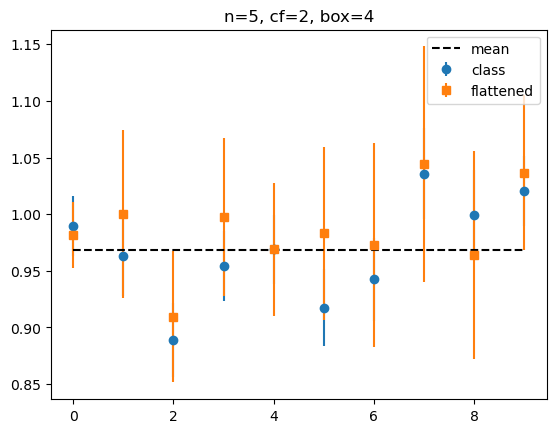

In [14]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(nframes_seq), cid_seq_frac[:,0], yerr=cid_seq_frac[:,1], fmt='o', label=f'class')
ax.errorbar(np.arange(nframes_seq), cid_seq_frac[:,2], yerr=cid_seq_frac[:,3], fmt='s', label=f'flattened')
ax.hlines(np.nanmean(cid_seq_frac[:,0]), 0, nframes_seq-1, colors='k', linestyles='dashed', label='mean')
print(f"Mean CID class: {np.nanmean(cid_seq_frac[:,0]):.4f} +/- {np.nanstd(cid_seq_frac[:,0]):.3f}")
print(f"Mean CID flattened: {np.nanmean(cid_seq_frac[:,2]):.4f} +/- {np.nanstd(cid_seq_frac[:,2]):.3f}")
ax.set_title(f"n={nbits}, cf={compression_factor}, box={coarse_graining_box_length}")
ax.legend()

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(ncubes), cid_frac_arr[:,0], yerr=cid_frac_arr[:,1], fmt='o', label=f'act={act}, exp={num_exp}')
ax.hlines(np.nanmean(cid_frac_arr[:,0]), 0, ncubes-1, colors='k', linestyles='dashed', label='mean')
print(f"Mean CID: {np.nanmean(cid_frac_arr[:,0]):.3f} +/- {np.nanstd(cid_frac_arr[:,0]):.3f}")
ax.set_title(f"n={nbits}, cf={compression_factor}, box={coarse_graining_box_length}")

Mean CID: 0.947 +/- 0.011


Text(0.5, 1.0, 'n=5, cf=2, box=4')

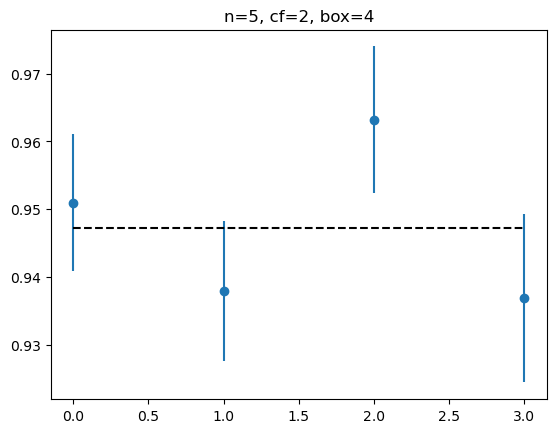

In [242]:
fig, ax = plt.subplots()
ax.errorbar(np.arange(ncubes), cid_frac_arr[:,0], yerr=cid_frac_arr[:,1], fmt='o', label=f'act={act}, exp={num_exp}')
ax.hlines(np.nanmean(cid_frac_arr[:,0]), 0, ncubes-1, colors='k', linestyles='dashed', label='mean')
print(f"Mean CID: {np.nanmean(cid_frac_arr[:,0]):.3f} +/- {np.nanstd(cid_frac_arr[:,0]):.3f}")
ax.set_title(f"n={nbits}, cf={compression_factor}, box={coarse_graining_box_length}")

#### Coarse-graining 1 window 1 hypercube

In [ ]:
## thinks:
# dynamic coarse graining box size based on defect density?
# allowing for dynamic nframes to get hypercube slices in time?

compression_factor = 2
coarse_graining_box_length = 4
nframes, nx, ny = 32, d_cluster_l['LX'], d_cluster_l['LX']

observation_window_bounds = [(0, int(nx / compression_factor)), (0, int(ny / compression_factor))]
lx_window = observation_window_bounds[0][1] - observation_window_bounds[0][0]
ly_window = observation_window_bounds[1][1] - observation_window_bounds[1][0]

lx_window_cg = lx_window // coarse_graining_box_length
ly_window_cg = ly_window // coarse_graining_box_length




defect_grid = np.zeros((nframes, lx_window_cg, ly_window_cg), dtype=int)
defect_count_full = []
defect_count = []

print(f"Using window size {lx_window}x{ly_window}.")
print(f"Defect grid shape with coarse graining box length {coarse_graining_box_length}: {defect_grid.shape}")

nbits_frame = int(np.log2(lx_window_cg))

if not lx_window_cg == ly_window_cg:
    raise ValueError("Cg observation windows must be square.")

allowed_intervals_list = get_allowed_time_intervals(system_size = lx_window_cg  , nbits_max=8)

# check that nframes is in allowed intervals
if nframes not in [ai['time_interval'] for ai in allowed_intervals_list]:
    raise ValueError(f"nframes {nframes} is not in allowed intervals {allowed_intervals_list}")
else:
    # get nbits for nframes
    nbits = [ai['nbits'] for ai in allowed_intervals_list if ai['time_interval'] == nframes][0]

print(f"Using nbits = {nbits} (size {1 << nbits}) for nframes = {nframes} and cg window size {lx_window_cg}x{ly_window_cg}")

for i, defect in enumerate(top_defects[-nframes:]):
    def_arr = get_defect_arr_from_frame(defect).astype(int)
   # print(len(def_arr   ))
    def_arr_xmask = (observation_window_bounds[0][0] < def_arr[:,0]) & (def_arr[:,0] < observation_window_bounds[0][1])
    def_arr_ymask = (observation_window_bounds[0][0] < def_arr[:,1]) & (def_arr[:,1] < observation_window_bounds[0][1])
    def_arr = def_arr[def_arr_xmask & def_arr_ymask]

    defect_count_full.append(len(def_arr))

    local_x = def_arr[:, 0] - observation_window_bounds[0][0]
    local_y = def_arr[:, 1] - observation_window_bounds[1][0]

    # Coarse-grain: map positions to coarse grid indices
    coarse_x = (local_x // coarse_graining_box_length).astype(int)
    coarse_y = (local_y // coarse_graining_box_length).astype(int)

    # Set coarse cells to 1 if any defect is inside
    defect_grid[i, coarse_x, coarse_y] = 1
    defect_count.append(defect_grid[i,:,:].sum())

print("Average number of defects in window before/after coarse graining: ", np.mean(defect_count_full), np.mean(defect_count))
print("defects lost in coarse graining per frame: ", np.mean(np.array(defect_count_full) - np.array(defect_count)))

#### data structure exploration

In [ ]:
nbits=4
dim=2
size=1<<nbits
x=np.linspace(1, size**2 , size**2).reshape(-1,size)
x=np.repeat(x[None,:,:,], size, axis=0)
x += np.array([0,100,200,300])[:,None,None]
x=x.astype(np.uint8)
data = np.transpose(x[0]).reshape((-1, ) + (1<<nbits, ) * dim).T
data.squeeze()
x

In [ ]:
nbits=3
size=1<<nbits
dim=3
L, Nt = 16,2
L, Nt = 8,8
multiplier = 100 if L==8 else 1000
nbits_frame = int(np.log2(L))

x=np.linspace(1, L**2 , L**2).reshape(-1,L)
x=np.repeat(x[None,:,:,], Nt, axis=0)
x += np.arange(0, multiplier * Nt, multiplier)[:,None,None]
x = x.astype(np.uint16)
x[0]
#data = np.transpose(x[0]).reshape((-1, ) + (1<<nbits, ) * dim).T
#data[:,:,:].squeeze()


In [ ]:
for order in itter_hscan(x, dim=3,nbits=nbits):
    print(order[-10:])

In [ ]:
data = np.transpose(x).reshape((-1, ) + (1<<nbits, ) * dim).T
data[:,:,:].squeeze()

for order in itter_hscan(data, dim=3,nbits=nbits):
    print(order[-1:])

In [ ]:

for order in itter_hscan(x[0], dim=2,nbits=nbits_frame):
    print(cid(order))

In [ ]:

for order in itter_hscan(data, dim=2,nbits=nbits_frame):
    print(order)